In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import json
import os
from glob import glob
from subprocess import call
import time
from joblib import Parallel, delayed

In [4]:
imgs = [nib.load(f"/content/drive/My Drive/BraTS2021_Training_Data/BraTS2021_00062/BraTS2021_00062_{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 80] for m in ["flair", "t1", "t1ce", "t2"]]
lbl = nib.load("/content/drive/My Drive/BraTS2021_Training_Data/BraTS2021_00062/BraTS2021_00062_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, 80]

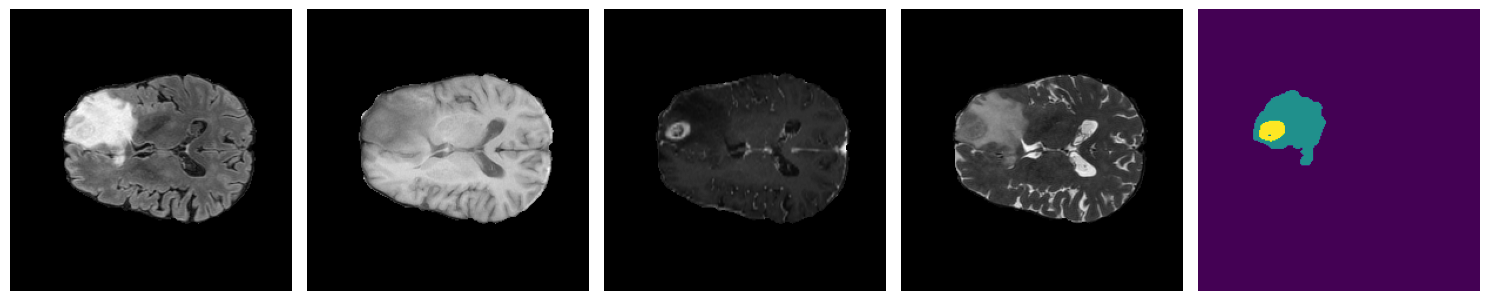

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Cargar el archivo NIfTI desde el directorio
def load_nifty(directory, example_id, suffix):
    return nib.load(os.path.join(directory, example_id + "_" + suffix + ".nii.gz"))

# Cargar todos los canales (flair, t1, t1ce, t2)
def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["flair", "t1", "t1ce", "t2"]]

# Obtener datos en un formato específico (preprocesamiento básico)
def get_data(nifty, dtype="int16"):
    # Convertir los datos a int16 y manejar valores anómalos
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0  # Corregir valores erróneos comunes en NIfTI
        return data
    # Convertir segmentaciones a uint8, dado que son etiquetas discretas
    return nifty.get_fdata().astype(np.uint8)

# Aplicar preprocesamiento a las imágenes antes de guardarlas
def preprocess_images(channels):
    # Ejemplo de preprocesamiento: normalización de intensidades
    # Normalizamos cada canal individualmente a la escala [0, 1]
    return [(channel - np.min(channel)) / (np.max(channel) - np.min(channel)) for channel in channels]

# Preparar y guardar las imágenes y las etiquetas en formato .nii.gz
def prepare_nifty(d, img_save_dir, lbl_save_dir):
    example_id = d.split("/")[-1]

    # Cargar los canales de imágenes multimodales (flair, t1, t1ce, t2)
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header

    # Preprocesamiento: obtener los datos de las imágenes y normalizar
    flair_data = get_data(flair)
    t1_data = get_data(t1)
    t1ce_data = get_data(t1ce)
    t2_data = get_data(t2)
    images = preprocess_images([flair_data, t1_data, t1ce_data, t2_data])

    # Apilar los canales procesados en un solo volumen (último eje)
    vol = np.stack(images, axis=-1)

    # Guardar la imagen preprocesada como archivo NIfTI
    vol_nifti = nib.Nifti1Image(vol, affine, header=header)
    nib.save(vol_nifti, os.path.join(img_save_dir, example_id + ".nii.gz"))

    # Procesar y guardar la segmentación si existe
    seg_path = os.path.join(d, example_id + "_seg.nii.gz")
    if os.path.exists(seg_path):
        seg = load_nifty(d, example_id, "seg")
        seg_data = get_data(seg, "uint8")

        # Modificar la etiqueta 4 (tumor edema) a 3 para simplificar el modelo
        seg_data[seg_data == 4] = 3

        # Guardar la segmentación procesada como archivo NIfTI
        seg_nifti = nib.Nifti1Image(seg_data, seg.affine, header=seg.header)
        nib.save(seg_nifti, os.path.join(lbl_save_dir, example_id + "_seg.nii.gz"))

# Paralelizar el procesamiento de los datos en múltiples núcleos
def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(*arg) for arg in args)

# Función principal para preparar el conjunto de datos completo
def prepare_dataset(data):
    img_save_dir = "/content/drive/My Drive/BraTS2021_Preprocessed_Data/images"
    lbl_save_dir = "/content/drive/My Drive/BraTS2021_Preprocessed_Data/labels"

    # Crear directorios si no existen
    os.makedirs(img_save_dir, exist_ok=True)
    os.makedirs(lbl_save_dir, exist_ok=True)

    print(f"Preparando el conjunto de datos BraTS21 desde: {data}")
    start = time.time()

    # Obtener todos los directorios de ejemplos en el conjunto de datos
    dirs = sorted(glob(os.path.join(data, "BraTS*")))

    # Procesar los datos de manera paralela
    run_parallel(prepare_nifty, [(d, img_save_dir, lbl_save_dir) for d in dirs])

    end = time.time()
    print(f"Tiempo de preparación: {(end - start):.2f} segundos")

# Ejecutar la preparación del conjunto de datos
prepare_dataset("/content/drive/My Drive/BraTS2021_Training_Data")
print("¡Proceso completado!")

Preparando el conjunto de datos BraTS21 desde: /content/drive/My Drive/BraTS2021_Training_Data
Tiempo de preparación: 403.53 segundos
¡Proceso completado!


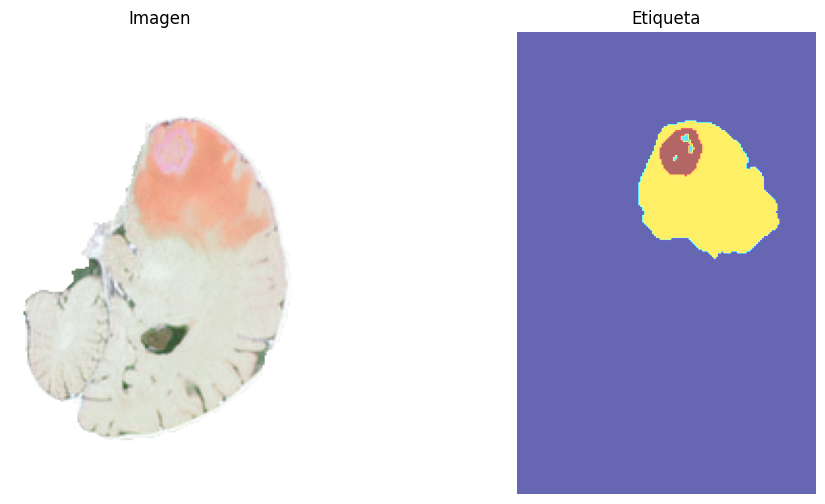

In [42]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Función para cargar datos NIfTI
def load_nifty_data(directory, example_id):
    file_path = os.path.join(directory, example_id + ".nii.gz")
    return nib.load(file_path).get_fdata()

# Función para graficar imagen y su etiqueta
def plot_image_and_label(img_data, lbl_data, slice_index):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Graficar la imagen
    axs[0].imshow(img_data[slice_index, :, :], cmap='gray')
    axs[0].set_title('Imagen')
    axs[0].axis('off')

    # Graficar la etiqueta
    axs[1].imshow(lbl_data[slice_index, :, :], cmap='jet', alpha=0.6)  # Usar 'jet' para etiquetas
    axs[1].set_title('Etiqueta')
    axs[1].axis('off')

    plt.show()

# Directorio de datos y ID de ejemplo
data_dir = "/content/drive/My Drive/BraTS2021_Preprocessed_Data/images"
label_dir = "/content/drive/My Drive/BraTS2021_Preprocessed_Data/labels"
example_id = "BraTS2021_00062"  # Cambia esto por el ID que necesites

# Cargar datos NIfTI
img_data = load_nifty_data(data_dir, example_id)  # Cambia la extensión si es diferente
lbl_data = load_nifty_data(label_dir, example_id + "_seg")  # Cambia la extensión si es diferente

# Graficar una rebanada del volumen
slice_index = 100  # Tomar una rebanada en el medio del eje Z
plot_image_and_label(img_data, lbl_data, slice_index)